# 02-750 HW 3 
## Exercise 1
### Anushka Sinha (anushka3)

### Imports

In [67]:
import pandas as pd 
import numpy as np
import math
import random
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


### Data

In [68]:
data = pd.read_csv("ex1_data.csv")
shuffled_data = shuffle(data, random_state=42)
data_array = shuffled_data.to_numpy()

In [69]:
random_seeds = []
for i in range(10):
    random.seed(100*i)
    random_seeds.append(random.randint(1, 100))
random_seeds

[50, 19, 6, 77, 40, 60, 34, 22, 86, 80]

### 1a. Implement a Design of Experiments (DOE) strategy of your choice.  Generate a plot comparing the performance (and standard deviation) on unobserved instances between your DOE strategy against passive learning and uncertainty sampling (Exercise 3 of Homework 1) after 30 observations across 10 simulations.

### DOE

In [71]:
# Create 100000 combinations of size k from the data
def generate_random_sets(dataset_array, k):
    size_of_data = len(dataset_array)
    num_combinations = 1000000
    indices_set_30 = set()
    while len(indices_set_30) < num_combinations:
        indices_set_30.add(tuple(np.random.choice(size_of_data, k, replace=False)))
    return indices_set_30
# Get 100000 sets of 30 
sets_of_30 = generate_random_sets(data_array, 30)

# Calculate the D-optimality 
def calc_D_optimality(X_samples):
    prod = np.matmul(X_samples.T, X_samples)
    det = np.linalg.det(prod)
    return det 

# Get the set of size k that maximizes the D-optimality
def DOE(dataset_array, sets_of_k):
    max_det = 0
    selected_set = None 
    for indices in sets_of_k:
        k_from_data = dataset_array[indices, :-1]
        current_set = indices
        current_det = calc_D_optimality(k_from_data)
        if current_det > max_det:
            max_det = current_det
            selected_set = current_set
    return selected_set

# Use this function to run D-optimality DOE simulations for sets of size k 
def run_simulations_DOE(dataset_array, sets, seed):
    all_indices = np.arange(len(dataset_array))
    # Get the set that maximizes the D-optimality
    best_set = DOE(dataset_array, sets)
    train_X = dataset_array[best_set, :-1]
    train_y = dataset_array[best_set, -1]
    # Get the set that is not present in the best set
    test_indices = np.setdiff1d(all_indices, best_set)
    test_X = dataset_array[test_indices, :-1]
    test_y = dataset_array[test_indices, -1]
    model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=seed)
    model.fit(train_X, train_y)
    # Get predictions on the indices that are not in best set
    y_pred = model.predict(test_X)
    mse = mean_squared_error(test_y, y_pred)
    return mse
# run_simulations_DOE(data_array, sets_of_30, 20)

In [72]:
# Running DOE
sets_of_30 = generate_random_sets(data_array, 30)
mse_scores_all_seeds_DOE = []

for seed in tqdm(random_seeds):
    mse_score = run_simulations_DOE(data_array, sets_of_30, seed)
    mse_scores_all_seeds_DOE.append(mse_score)
avg_mse_DOE = np.mean(mse_scores_all_seeds_DOE, axis=0)
std_mse_DOE = np.std(mse_scores_all_seeds_DOE, axis=0)
print("The average MSE score using DOE is ", avg_mse_DOE)

100%|██████████| 10/10 [01:15<00:00,  7.60s/it]

The average MSE score using DOE is  2.493079890136789


### Activer Learning - Uncertainty Sampling

In [73]:
def sigma_squared(predictions, true_vals, num_features):
    diff_sqrd = np.sum((true_vals - predictions) ** 2)
    den = len(true_vals) - num_features - 1
    return diff_sqrd/den

def calc_variances(train_X, test_x, sig_sqr):
    # Calculate (X'X)^-1
    XtX_inv = np.linalg.inv(train_X.T @ train_X)
    variances = []
    for i in test_x:
        prod = i @ (XtX_inv) @ (i.T)
        prod = sig_sqr * prod
        variances.append(prod)
    return variances

def regression_active_learning(d, seed):
    total_length = d.shape[0]
    # Target legnth is 30% of the data
    target_length = int(total_length * 0.3)  

    # Start with 10% of the data
    indices = np.arange(total_length)
    selected_indices, remaining_indices = train_test_split(indices, test_size=0.9, random_state=seed)

    # Run the loop until the sample data includes 30% of the original data
    while len(selected_indices) < target_length:
        # Prepare training and testing sets
        X_train, y_train = d[selected_indices, :-1], d[selected_indices, -1]
        X_test, y_test = d[remaining_indices, :-1], d[remaining_indices, -1]

        # Training the model
        model = RandomForestRegressor(random_state=seed)
        model.fit(X_train, y_train)
        train_preds = model.predict(X_train)

        # Calculate sigma squared
        sig_sqr = sigma_squared(train_preds, y_train, X_train.shape[1])

        # Calculate variances for remaining data
        variances = calc_variances(X_train, X_test, sig_sqr)

        # Get the index of the highest variance
        highest_variance_index = np.argmax(variances)
        selected_indices = np.append(selected_indices, remaining_indices[highest_variance_index])

        # Update the remaining indices
        remaining_indices = np.delete(remaining_indices, highest_variance_index)

    # Final training with the selected indices
    train_X, train_y = d[selected_indices, :-1], d[selected_indices, -1]
    test_indices = np.setdiff1d(indices, selected_indices)
    test_X, test_y = d[test_indices, :-1], d[test_indices, -1]

    model.fit(train_X, train_y)
    y_pred = model.predict(test_X)
    mse = mean_squared_error(test_y, y_pred)
    return mse

In [74]:
# Running Active Learning 
mse_scores_all_seeds_uncertainty_sampling = []

for seed in tqdm(random_seeds):
    mse_score = regression_active_learning(data_array, seed)
    mse_scores_all_seeds_uncertainty_sampling.append(mse_score)
avg_mse_uncertainty_sampling = np.mean(mse_scores_all_seeds_uncertainty_sampling, axis=0)
std_mse_uncertainty_sampling = np.std(mse_scores_all_seeds_uncertainty_sampling, axis=0)
print("The average MSE score using uncertainty sampling (active learning) is ", avg_mse_uncertainty_sampling)

100%|██████████| 10/10 [00:10<00:00,  1.06s/it]

The average MSE score using uncertainty sampling (active learning) is  3.1555567717791027


### Passive Learning 

In [75]:
def regression_passive_learning(d, seed):
    total_length = d.shape[0]
    # Target legnth is 30% of the data
    target_length = int(total_length * 0.3) 

    # Start with 10% of the data
    indices = np.arange(total_length)
    selected_indices, remaining_indices = train_test_split(indices, test_size=0.9, random_state=seed)

    model = RandomForestRegressor(random_state=seed)

    while len(selected_indices) < target_length:
        # Randomly select an index to add
        idx_to_add = np.random.choice(remaining_indices, 1, replace=False)
        selected_indices = np.append(selected_indices, idx_to_add)

        # Update the remaining indices
        remaining_indices = np.delete(remaining_indices, np.where(remaining_indices == idx_to_add))

    # Final training with the selected indices
    train_X, train_y = d[selected_indices, :-1], d[selected_indices, -1]
    test_indices = np.setdiff1d(indices, selected_indices)
    test_X, test_y = d[test_indices, :-1], d[test_indices, -1]

    model.fit(train_X, train_y)
    y_pred = model.predict(test_X)
    mse = mean_squared_error(test_y, y_pred)
    return mse

In [76]:
# Running Passive Learning 
mse_scores_all_seeds_passive_learning = []

for seed in tqdm(random_seeds):
    mse_score = regression_passive_learning(data_array, seed)
    mse_scores_all_seeds_passive_learning.append(mse_score)
avg_mse_passive_learning = np.mean(mse_scores_all_seeds_passive_learning, axis=0)
std_acc_passive_learning = np.std(mse_scores_all_seeds_passive_learning, axis=0)
print("The average MSE score using passive learning is ", avg_mse_passive_learning)

100%|██████████| 10/10 [00:00<00:00, 19.76it/s]

The average MSE score using passive learning is  1.9680877095879397


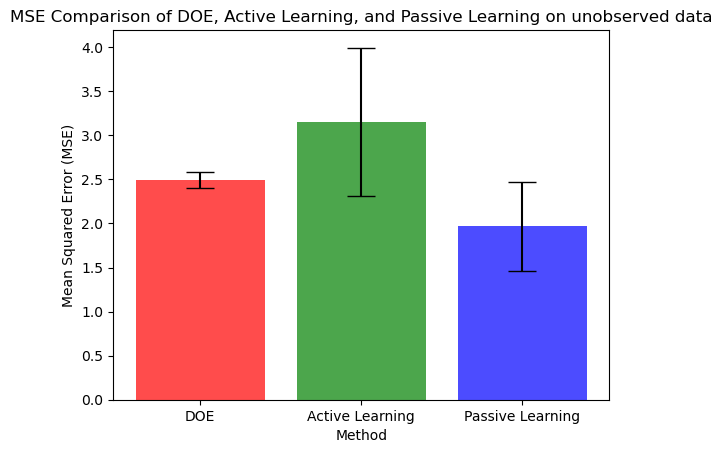

In [79]:
methods = ['DOE', 'Active Learning', 'Passive Learning']
mse_means = [avg_mse_DOE, avg_mse_uncertainty_sampling, avg_mse_passive_learning]  
mse_stds = [std_mse_DOE, std_mse_uncertainty_sampling, std_acc_passive_learning] 
x_pos = np.arange(len(methods))
plt.bar(x_pos, mse_means, yerr=mse_stds, align='center', alpha=0.7, capsize=10, color=['red', 'green', 'blue'])


plt.xlabel('Method')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE Comparison of DOE, Active Learning, and Passive Learning on unobserved data')
plt.xticks(x_pos, methods)


plt.show()

### 1b. Run active learning simulations using uncertainty sampling and your favorite base learner on the regression dataset. For one set of simulations, initialize with 10 randomly selected instances. For another set of simulations, initialize with 10 DOE selected instances. Continue both types of simulations until 50 instances are observed. In a single plot, show the performance (and standard deviation) of predictions on the unobserved set as a function of the number of instances observed.

In [86]:
def active_learning_random_initialization(d, seed):
    total_length = d.shape[0]
    target_length = int(total_length * 0.5) 
    indices = np.arange(total_length)
    # Randomly intialize the train and test set
    selected_indices, remaining_indices = train_test_split(indices, test_size=0.9, random_state=seed)
    mse_scores = []

    # Run the active learning loop until the sample data includes 50% of the original data
    while len(selected_indices) < target_length:
        # Prepare training and testing sets
        X_train, y_train = d[selected_indices, :-1], d[selected_indices, -1]
        X_test, y_test = d[remaining_indices, :-1], d[remaining_indices, -1]

        # Training the model
        model = RandomForestRegressor(random_state=seed)
        model.fit(X_train, y_train)
        train_preds = model.predict(X_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)

        # Calculate sigma squared
        sig_sqr = sigma_squared(train_preds, y_train, X_train.shape[1])

        # Calculate variances for remaining data
        variances = calc_variances(X_train, X_test, sig_sqr)

        # Get the index of the highest variance
        highest_variance_index = np.argmax(variances)
        selected_indices = np.append(selected_indices, remaining_indices[highest_variance_index])

        # Update the remaining indices
        remaining_indices = np.delete(remaining_indices, highest_variance_index)

    return mse_scores


In [87]:
# Running active learning using random initialization
mse_scores_random_initialization = []

for seed in tqdm(random_seeds):
    mse_score = active_learning_random_initialization(data_array, seed)
    mse_scores_random_initialization.append(mse_score)
avg_mse_random_ini = np.mean(mse_scores_random_initialization, axis=0)
std_mse_random_ini = np.std(mse_scores_random_initialization, axis=0)
print("The average MSE score using active learning with random initialization is ", avg_mse_random_ini)

100%|██████████| 10/10 [00:21<00:00,  2.20s/it]

The average MSE score using active learning with random initialization is  [6.3938208  5.40302175 5.29974001 5.42507182 5.58640895 5.01563188
 4.73029697 4.39306922 4.10334539 4.12338374 4.08987994 3.9435738
 3.93923274 3.8950504  3.90917258 3.92526677 3.75281606 3.65309373
 3.47595363 3.21568091 3.15555677 3.05309033 2.94984671 2.9348522
 2.84733268 2.56962102 2.51517732 2.56547748 2.59036934 2.5747236
 2.53845985 2.5207432  2.63499407 2.64344124 2.72595705 2.75562969
 2.7997446  2.82816955 2.69439407 2.67601673]


In [89]:
def active_learning_DOE_initialization(d, seed):
    total_length = d.shape[0]
    target_length = int(total_length * 0.5) 
    indices = np.arange(total_length)
    sets_of_10 = generate_random_sets(data_array, 10)
    # Initialize the train set based on the best set of 30 indices selected by DOE 
    selected_indices = DOE(d, sets_of_10)
    remaining_indices = np.setdiff1d(indices, selected_indices)
    mse_scores = []

    # Run the active learning loop until the sample data includes 50% of the original data
    while len(selected_indices) < target_length:
        # Prepare training and testing sets
        X_train, y_train = d[selected_indices, :-1], d[selected_indices, -1]
        X_test, y_test = d[remaining_indices, :-1], d[remaining_indices, -1]

        # Training the model
        model = RandomForestRegressor(random_state=seed)
        model.fit(X_train, y_train)
        train_preds = model.predict(X_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)

        # Calculate sigma squared
        sig_sqr = sigma_squared(train_preds, y_train, X_train.shape[1])

        # Calculate variances for remaining data
        variances = calc_variances(X_train, X_test, sig_sqr)

        # Get the index of the highest variance
        highest_variance_index = np.argmax(variances)
        selected_indices = np.append(selected_indices, remaining_indices[highest_variance_index])

        # Update the remaining indices
        remaining_indices = np.delete(remaining_indices, highest_variance_index)

    return mse_scores


In [90]:
# Running active learning using DOE initialization
mse_scores_DOE_initialization = []

for seed in tqdm(random_seeds):
    mse_score = active_learning_DOE_initialization(data_array, seed)
    mse_scores_DOE_initialization.append(mse_score)
avg_mse_DOE_ini = np.mean(mse_scores_DOE_initialization, axis=0)
std_mse_DOE_ini = np.std(mse_scores_DOE_initialization, axis=0)
print("The average MSE score using active learning with DOE initialization is ", avg_mse_DOE_ini)

100%|██████████| 10/10 [02:55<00:00, 17.54s/it]

The average MSE score using active learning with DOE initialization is  [13.42098772 13.37556234 10.99239274  9.10014832  8.5232305   7.7627715
  7.17252202  6.68103751  6.27420527  6.02720785  5.68669855  5.59779196
  5.35638716  5.45536146  5.49497634  5.22011009  5.0624295   4.99943221
  4.71131082  4.65086241  4.66197619  5.21063091  5.5909101   5.75444889
  5.80965518  5.4619934   5.53779702  5.72259234  5.74911205  5.98048525
  5.8288981   5.9524534   5.92856239  6.02287422  5.06675652  5.48412601
  4.93945167  4.99286052  5.14285868  5.46257925]


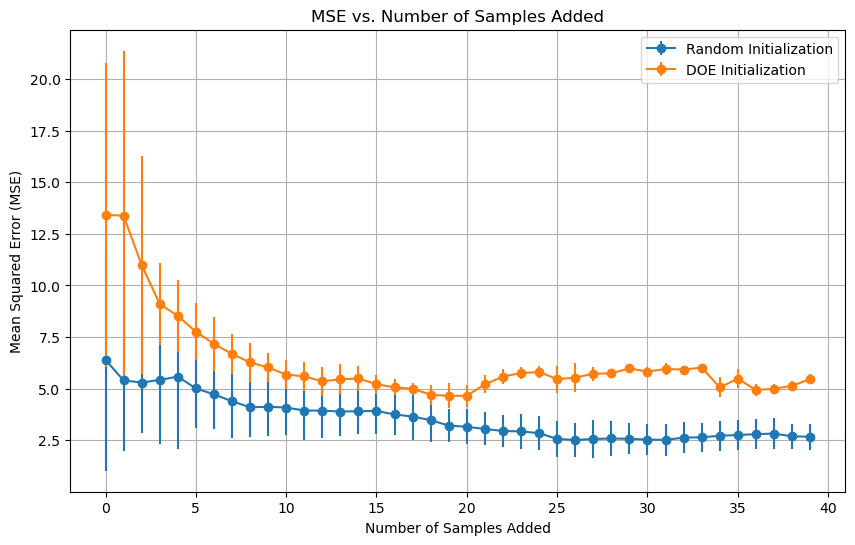

In [91]:
samples_added = np.arange(len(avg_mse_random_ini))

plt.figure(figsize=(10, 6))
plt.errorbar(samples_added, avg_mse_random_ini, yerr=std_mse_random_ini, label='Random Initialization', fmt='-o')
plt.errorbar(samples_added, avg_mse_DOE_ini, yerr=std_mse_DOE_ini, label='DOE Initialization', fmt='-o')

plt.xlabel('Number of Samples Added')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs. Number of Samples Added')
plt.legend()
plt.grid(True)
plt.show()